# Boston Housing Prices

Boston housing dataset.

In [1]:
import os
import json

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113)

In [3]:
print(f"\tInput Shape:  {x_train.shape}")
print(f"\tOutput Shape: {y_train.shape}")

	Input Shape:  (404, 13)
	Output Shape: (404,)


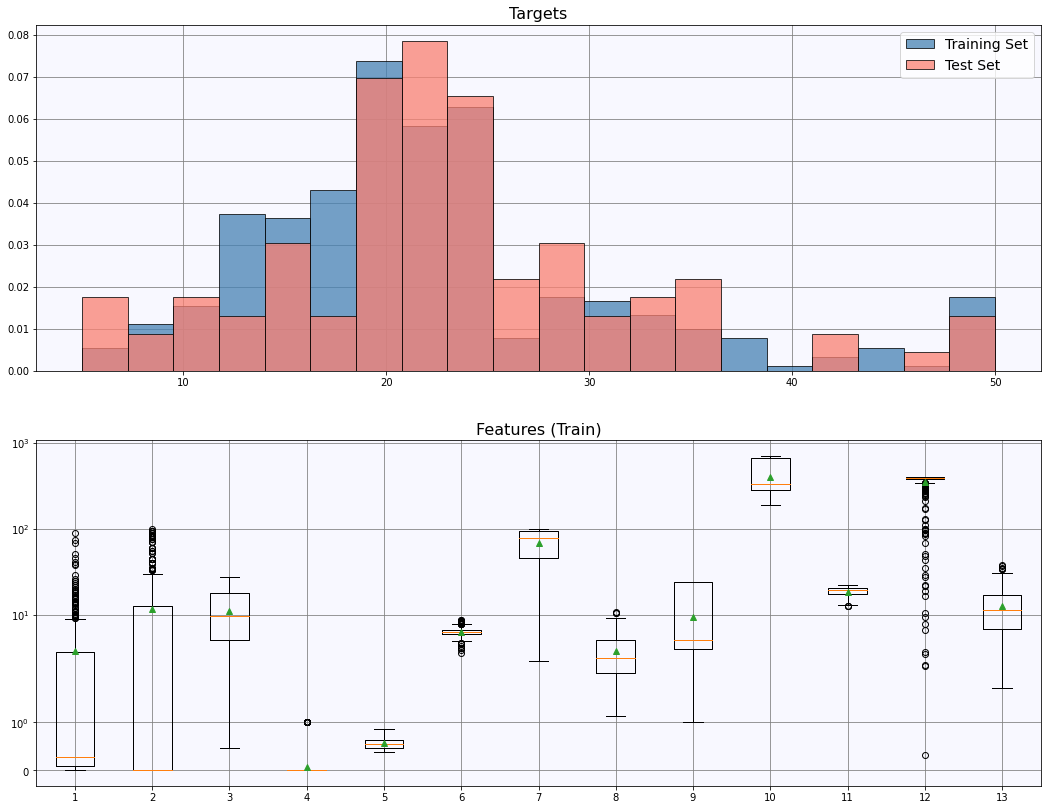

In [4]:
num_bins = 20
bin_width = (np.amax(y_train) - np.amin(y_train)) / num_bins

fig = plt.figure(figsize=(18., 14.))
ax1 = plt.subplot(2, 1, 1)
ax1.set_title("Targets", fontsize=16)
_, bins, _ = ax1.hist(y_train, bins=num_bins, density=True, width=(1.0 * bin_width), align="mid",
                      alpha=0.75, color="steelblue", edgecolor="black", label="Training Set")
_, bins, _ = ax1.hist(y_test, bins=bins, density=True, width=(1.0 * bin_width), align="mid",
                      alpha=0.75, color="salmon", edgecolor="black", label="Test Set")
ax1.set_facecolor("ghostwhite")
ax1.grid(color="gray")
ax1.set_axisbelow(True)
ax1.legend(fontsize=14)
#
ax2 = plt.subplot(2, 1, 2)
ax2.set_title("Features (Train)", fontsize=16)
ax2.boxplot(x_train, showmeans=True)
ax2.set_facecolor("ghostwhite")
ax2.grid(color="gray")
ax2.set_axisbelow(True)
ax2.set_yscale("symlog")
plt.show()

# Input Normalization:

In [5]:
train_means = np.mean(x_train, axis=0)
train_stds = np.std(x_train, axis=0)
    
def normalize_features(
    x, means=train_means, stds=train_stds):
    """Column-wise normalizes the inputs.
    
    Args:
        x (np.ndarray): Input array of n samples and m features.
        means (np.ndarray): Means to uses for normalization.
        stds (np.ndarray): Standard deviations used for normalization.
    
    Returns:
        normalized array.
    """
    means = means[np.newaxis, :]
    stds = stds[np.newaxis, :]
    x = x - means;
    x = np.divide(x, stds, out=np.zeros_like(x), where=(stds != 0))
    return x

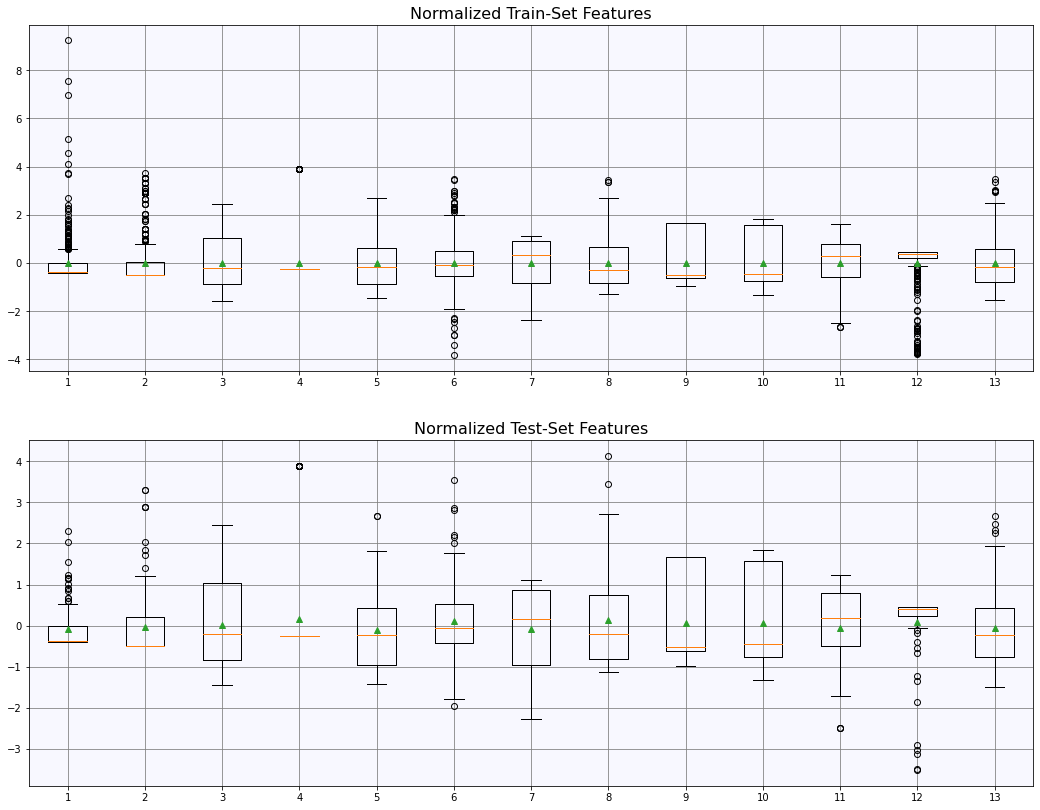

In [6]:
fig = plt.figure(figsize=(18., 14.))
#
ax1 = plt.subplot(2, 1, 1)
ax1.set_title("Normalized Train-Set Features", fontsize=16)
ax1.boxplot(normalize_features(x_train), showmeans=True)
ax1.set_facecolor("ghostwhite")
ax1.grid(color="gray")
ax1.set_axisbelow(True)
ax1.set_yscale("linear")
#
ax2 = plt.subplot(2, 1, 2)
ax2.set_title("Normalized Test-Set Features", fontsize=16)
ax2.boxplot(normalize_features(x_test), showmeans=True)
ax2.set_facecolor("ghostwhite")
ax2.grid(color="gray")
ax2.set_axisbelow(True)
ax2.set_yscale("linear")
#
plt.show()

# Construct a Regression Model:

In [7]:
inputs = tf.keras.Input(
    shape=(13,),
    name="input")
x = tf.keras.layers.Dense(
    64, 
    activation=tf.keras.activations.tanh,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    name="dense_1"
)(inputs)
x = tf.keras.layers.Dense(
    32, 
    activation=tf.keras.activations.tanh,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    name="dense_2"
)(x)
outputs = tf.keras.layers.Dense(
    1, 
    activation=tf.keras.activations.linear,
    use_bias=True,
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    name="output"
)(x)
model = tf.keras.Model(
    inputs=inputs, 
    outputs=outputs,
    name="boston_house_appraiser")

In [8]:
model.summary(print_fn=(lambda *x: print("\t", *x)))

	 Model: "boston_house_appraiser"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input (InputLayer)           [(None, 13)]              0         
	 _________________________________________________________________
	 dense_1 (Dense)              (None, 64)                896       
	 _________________________________________________________________
	 dense_2 (Dense)              (None, 32)                2080      
	 _________________________________________________________________
	 output (Dense)               (None, 1)                 33        
	 Total params: 3,009
	 Trainable params: 3,009
	 Non-trainable params: 0
	 _________________________________________________________________


# Train Model

In [9]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
    epsilon=1e-07, amsgrad=False, name="Adam")

model.compile(optimizer=optimizer, loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error")])

In [10]:
# Learning rate schedule
def lr_schedule(epoch, lr):
    if (epoch < 10): return lr
    else: return 1.0 * lr
lr_schedule_callback = tf.keras.callbacks.LearningRateScheduler(
    schedule=lr_schedule, 
    verbose=0)

# Early stoppying callback:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.001, 
    patience=500, 
    verbose=1,
    mode="min", 
    baseline=None, 
    restore_best_weights=True)

# Fit model
fit_history = model.fit(
    x=normalize_features(x_train), 
    y=y_train,
    batch_size=32,
    epochs=10000,
    verbose=0,
    validation_split=0.2,
    shuffle=True,
    workers=8,
    callbacks=[
        lr_schedule_callback,
        early_stopping_callback
    ])

Restoring model weights from the end of the best epoch.
Epoch 02310: early stopping


In [11]:
eval_results = model.evaluate(normalize_features(x_train), y_train, 
                              return_dict=True, verbose=0)

print("Evaluation on the train set:")
print(f"\tMSE: {round(float(eval_results['loss']), 3)}")
print(f"\tRMS: {round(float(eval_results['root_mean_squared_error']), 3)}")

Evaluation on the train set:
	MSE: 4.292
	RMS: 2.072


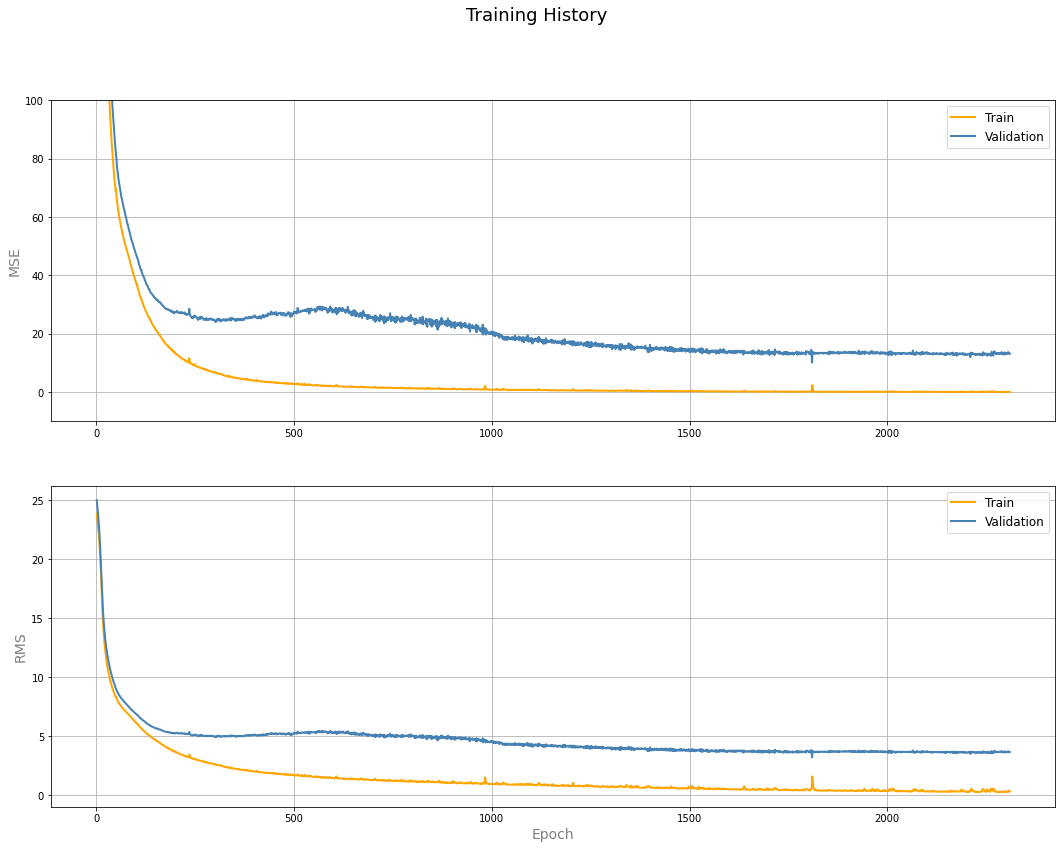

In [12]:
train_losses = fit_history.history["loss"]
val_losses = fit_history.history["val_loss"]
train_rms = fit_history.history["root_mean_squared_error"]
val_rms = fit_history.history["val_root_mean_squared_error"]
num_epochs = len(train_losses)
epochs = np.linspace(start=1, stop=num_epochs, num=num_epochs, endpoint=True)

fig = plt.figure(figsize=(18., 13.))
plt.suptitle("Training History", fontsize=18)
#
ax1 = plt.subplot(2, 1, 1)
# ax1.set_title("MSE", fontsize=18)
# ax1.set_xlabel("Epoch", fontsize=14., color="gray")
ax1.set_ylabel("MSE", fontsize=14., color="gray")
ax1.plot(epochs, train_losses, marker="", lw=2.0, color="orange", label="Train")
ax1.plot(epochs, val_losses, marker="", lw=2.0, color="steelblue", label="Validation")
ax1.set_ylim(-10.0, 100.0)
ax1.grid()
ax1.set_axisbelow(True)
ax1.legend(loc="upper right", fontsize=12)
#
ax2 = plt.subplot(2, 1, 2)
# ax2.set_title("RMS", fontsize=18)
ax2.set_xlabel("Epoch", fontsize=14., color="gray")
ax2.set_ylabel("RMS", fontsize=14., color="gray")
ax2.plot(epochs, train_rms, marker="", lw=2.0, color="orange", label="Train")
ax2.plot(epochs, val_rms, marker="", lw=2.0, color="steelblue", label="Validation")
# ax2.set_ylim(-1.0, 20.0)
ax2.grid()
ax2.set_axisbelow(True)
ax2.legend(loc="upper right", fontsize=12)
#
plt.show()

# Evaluate

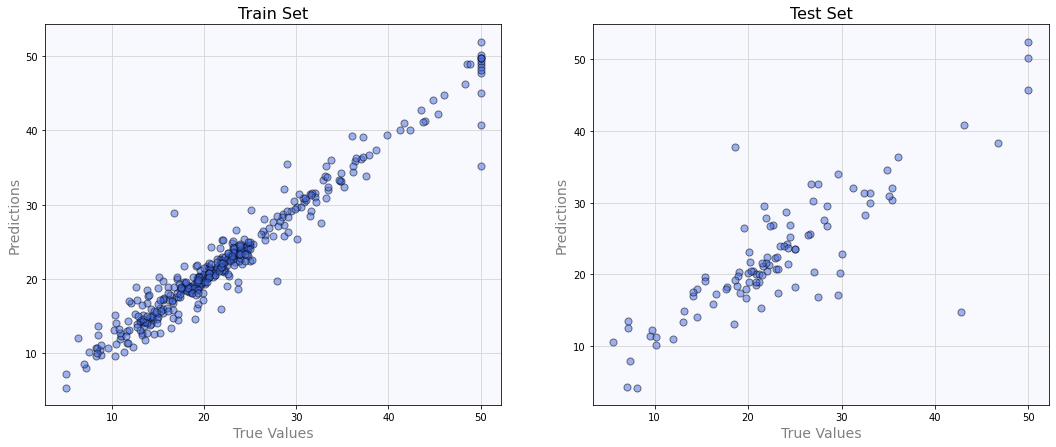

In [13]:
train_predictions = model.predict(normalize_features(x_train))
test_predictions = model.predict(normalize_features(x_test))

fig = plt.figure(figsize=(18., 7.))
#
ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Train Set", fontsize=16)
ax1.scatter(y_train, train_predictions, color="royalblue", s=50.0, edgecolor="black", alpha=0.5)
ax1.set_xlabel("True Values", fontsize=14, color="gray")
ax1.set_ylabel("Predictions", fontsize=14, color="gray")
ax1.set_facecolor("ghostwhite")
ax1.grid(color="lightgray")
ax1.set_axisbelow(True)
#
ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Test Set", fontsize=16)
ax2.scatter(y_test, test_predictions, color="royalblue", s=50.0, edgecolor="black", alpha=0.5)
ax2.set_xlabel("True Values", fontsize=14, color="gray")
ax2.set_ylabel("Predictions", fontsize=14, color="gray")
ax2.set_facecolor("ghostwhite")
ax2.grid(color="lightgray")
ax2.set_axisbelow(True)
#
plt.show()

In [14]:
eval_results = model.evaluate(normalize_features(x_test), y_test, 
                              return_dict=True, verbose=0)

print("Evaluation on the test set:")
print(f"\tMSE: {round(float(eval_results['loss']), 3)}")
print(f"\tRMS: {round(float(eval_results['root_mean_squared_error']), 3)}")

Evaluation on the test set:
	MSE: 24.744
	RMS: 4.974
